MEG Signal Analysis Using windowed PLV, PCA and Hierarchical Clustering
-----------------------------------------------------------------------

This notebook demonstrates MEG analysis using windowed Phase Locking Value (PLV), Principal Component Analysis (PCA) and hierarchical clustering. The notebook:
* Reads MEG ICANN 2011 dataset,
* Goes through the samples and splits them into 0.2s windows,
* Estimates interaction matrix for each window, and
* Projects the data into 2- and 3-dimensional planes.

For more information, please refer to https://nextonsblog.wordpress.com/?p=3087

In [1]:
import numpy as np
import scipy.io

from scipy.signal import hilbert

from sklearn.decomposition import PCA, FastICA

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
import matplotlib.colors as colors
%matplotlib inline

from IPython.display import HTML

In [2]:
# Global configuration.
FILENAME = "../../data/megicann_train_v2.mat"
DATASET_X = 'train_day1'
DATASET_Y = 'class_day1'
FREQ_DOMAINS = [5]
VALIDATION_SAMPLES = 0.2
WINDOW_LENGTH = 40

In [3]:
# Original data is in format train[frequency][sample, channel, time].
# make different frequencies appear as channels and swap channel and time.
def preprocess_x(raw_data):
    # Move different frequencies to channels
    samples = raw_data[0, FREQ_DOMAINS[0]][:]
    for freq_domain in FREQ_DOMAINS[1:]:
        samples = np.concatenate([samples, raw_data[0, freq_domain][:]], axis=1)
        
    # Normalize the data within each sample (per channel) and ensure that type is ok
    for i, sample in enumerate(samples):
        sample_mean = sample.mean(axis=1);
        sample_std = sample.std(axis=1);
        samples[i] = ((sample.transpose() - sample_mean) / sample_std).transpose()

    samples = hilbert(samples)
    
    # Transpose the data to [sample, time, channel] format
    samples = np.transpose(samples, axes=(0, 2, 1))
    
    return samples

In [4]:
# Compute windowed PLV for the data and return interaction matrix in format [sample, channel, channel]
def wplv(samples_x, samples_y, window_length):
    plvs = []
    y = []
    for sample_x, sample_y in zip(samples_x, samples_y):
        for i in range(sample_x.shape[0] - window_length):
            _sample = sample_x[i:i+window_length]
            plv = np.abs(np.dot(_sample.conj().T, _sample)) / window_length
            # The connectivity matrix is symmetrical. Look just the upper triangular matrix
            idx = np.triu_indices(plv.shape[0])
            plv = plv[idx[0],idx[1]]
            # Avoid memory exhaustion by thresholding data here and storing it as uint8
            plv[plv < 0.9] = 0
            plv[plv >= 0.9] = 1
            plv = np.uint8(plv)
            plvs.append(np.asarray(plv))
            y.append(sample_y)
        
    return np.asarray(plvs), np.asarray(y)

In [5]:
# Load samples and preprocess them
train_dict = scipy.io.loadmat(FILENAME)
train_dataset_x = preprocess_x(train_dict[DATASET_X])
train_dataset_y = train_dict[DATASET_Y][:,0]

# Pick up some characteristics of the data
num_samples = train_dataset_x.shape[0]
sample_length = train_dataset_x.shape[1]
num_channels = train_dataset_x.shape[2]

# Remove train_dict to save some memory
train_dict = None

In [6]:
# Compute PLVs
train_dataset_x, train_dataset_y = wplv(train_dataset_x, train_dataset_y, WINDOW_LENGTH)

# Update sample length
sample_length = sample_length - WINDOW_LENGTH

# Split samples into training and validation sets
num_val_samples = sample_length * int(np.ceil(VALIDATION_SAMPLES * num_samples))
val_dataset_x = train_dataset_x[:num_val_samples]
val_dataset_y = train_dataset_y[:num_val_samples]
train_dataset_x = train_dataset_x[num_val_samples:]
train_dataset_y = train_dataset_y[num_val_samples:]

In [7]:
# Initialize data for visualization
label_locations = np.arange(1, 5, 4.0 / 5.0) + (4.0 / 10.0)
label_colors = ['cyan', 'blue', 'gray', 'red', 'green']
labels = ['Artificial', 'Football', 'Nature', 'Bean', 'Chaplin']

In [9]:
# Project the preprocessed samples to 2 dimensional plane
pca = PCA(n_components=2)
train_dataset_x_projected = pca.fit(train_dataset_x[0:(100 * sample_length)]).transform(train_dataset_x)

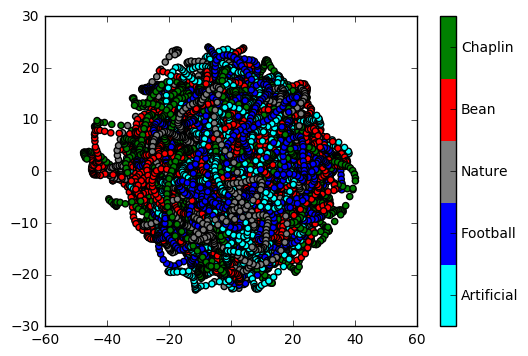

In [10]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
scatter = plt.scatter(train_dataset_x_projected[:,0],
                      train_dataset_x_projected[:,1],
                      c=train_dataset_y,
                      cmap=colors.ListedColormap(label_colors))

colorbar = plt.colorbar(scatter)
colorbar.set_ticks(label_locations)
colorbar.set_ticklabels(labels)

plt.show()

In [11]:
# Project the preprocessed samples to 3 dimensional plane
pca = PCA(n_components=3)
train_dataset_x_projected = pca.fit(train_dataset_x[0:(sample_length * 100)]).transform(train_dataset_x)

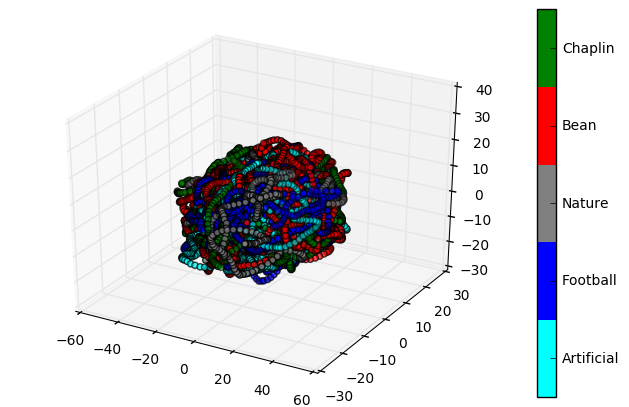

In [12]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(train_dataset_x_projected[:,0],
                     train_dataset_x_projected[:,1],
                     train_dataset_x_projected[:,2],
                     c=train_dataset_y,
                     cmap=colors.ListedColormap(label_colors))

colorbar = plt.colorbar(scatter)
colorbar.set_ticks(label_locations)
colorbar.set_ticklabels(labels)

plt.show()